In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from mlelec.data.dataset import precomputed_molecules, MoleculeDataset, MLDataset, get_dataloader
import torch
from ase.io import read
import ase
from mlelec.models.linear import LinearTargetModel
from mlelec.features.acdc import compute_features_for_target
from IPython.utils import io

In [3]:
import sys 
import pyscf, pyscfad
print(sys.version_info)
print(pyscf.__version__)
print(pyscfad.__version__)


sys.version_info(major=3, minor=11, micro=5, releaselevel='final', serial=0)
2.3.0
0.1.2


In [4]:
water_data = MoleculeDataset(mol_name='water_1000', frame_slice=slice(0,200),  device='cuda', aux=['overlap', 'orbitals'], target=["fock", "dipole_moment"])
ml_data = MLDataset(molecule_data=water_data, device ='cuda', model_strategy = "coupled")

ml_data._shuffle(random_seed=5380)
ml_data._split_indices(train_frac=0.7, val_frac=0.2)
#assumed args.model_type = 'acdc'
if ml_data.features is None: 
    ml_data._set_features(compute_features_for_target(ml_data, device='cuda'))

train_dl, val_dl, test_dl = get_dataloader(ml_data, model_return= 'tensor')
# next(iter(train_dl))

Loading structures
examples/data/water_1000/sto-3g/fock.hickle
examples/data/water_1000/sto-3g/dipole_moment.hickle
Computing features with default hypers


/home/nigam/miniconda3/lib/python3.11/site-packages/rascaline/systems/ase.py:57: UserWarning: periodic boundary conditions are disabled, but the cell matrix is not zero, we will set the cell to zero.
  warnings.warn(


## 1. Learn Hamiltonian then predict dipole

In [22]:
model = LinearTargetModel(dataset = ml_data, nlayers = 1, nhidden = 16, bias = False, device = 'cuda')

In [23]:
from cmath import inf
best = inf
early_stop_criteria =  10 

In [24]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=10, verbose=True)
import mlelec.metrics as mlmetrics
val_interval = 10
loss_fn = getattr(mlmetrics, 'L2_loss')
losses=[]
early_stop_count = 0


In [25]:
for epoch in range(800):
    # train_pred = []
    # target=[]
    model.train(True)
    train_loss =0
    for i, data in enumerate(train_dl):
        optimizer.zero_grad()
        pred = model(data['input'], return_type='tensor', batch_indices=data['idx'])
        # target.append(data['output'])
        # train_pred.append(pred)
        loss = loss_fn(pred, data['output'])
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    # train_loss = loss_fn(torch.cat(train_pred), torch.cat(target))
    # print(train_loss - epoch_loss)
    losses.append(train_loss)
    # scheduler.step(train_loss)
    model.train(False)

    if epoch% val_interval == 0:
        # val_pred = []
        # val= []
        val_loss = 0
        for i, data in enumerate(val_dl):
            pred = model(data['input'], return_type='tensor', batch_indices=data['idx'])
            vloss = loss_fn(pred, data['output'])
            val_loss += vloss.item()
            # val.append(data['output'])
            # val_pred.append(pred)
        new_best = val_loss < best 
        if new_best:
            best = val_loss
            torch.save(model.state_dict(), 'best_model.pt')
            early_stop_count = 0
        else: 
            early_stop_count+=1
        if early_stop_count > early_stop_criteria:
            print(f'Early stopping at epoch {epoch}')
            print(f'Epoch {epoch}, train loss {train_loss/len(ml_data.train_idx)}')

            print(f'Epoch {epoch} val loss {val_loss/len(ml_data.val_idx)}')
            # Save last best model
            break

        # val_loss = loss_fn(torch.cat(val_pred), torch.cat(val))
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, train loss {train_loss/len(ml_data.train_idx)}')

        print(f'Epoch {epoch} val loss {val_loss/len(ml_data.val_idx)}')
    

Epoch 0, train loss 462.95987853278535
Epoch 0 val loss 441.6532839589898
Epoch 10, train loss 5.8631769241150575
Epoch 10 val loss 3.766819132877007
Epoch 20, train loss 1.9318194083224345
Epoch 20 val loss 1.8118898962798404
Epoch 30, train loss 1.3506038389008153
Epoch 30 val loss 1.2654273477733144
Epoch 40, train loss 1.0305076747323796
Epoch 40 val loss 0.9843053593080245
Epoch 50, train loss 0.8857030108592749
Epoch 50 val loss 0.7242746097896844
Epoch 60, train loss 1.017152272278283
Epoch 60 val loss 0.8919096019890216
Epoch 70, train loss 0.8431376878419865
Epoch 70 val loss 0.8994411199714145
Epoch 80, train loss 0.9008245495295076
Epoch 80 val loss 0.6799362415339285
Epoch 90, train loss 0.8556155980885519
Epoch 90 val loss 0.5966697051283202
Epoch 100, train loss 0.964322425665469
Epoch 100 val loss 0.7399460882062244
Epoch 110, train loss 0.8939658596937357
Epoch 110 val loss 0.8117343962133475
Epoch 120, train loss 0.9059325448372387
Epoch 120 val loss 0.6516525941604734

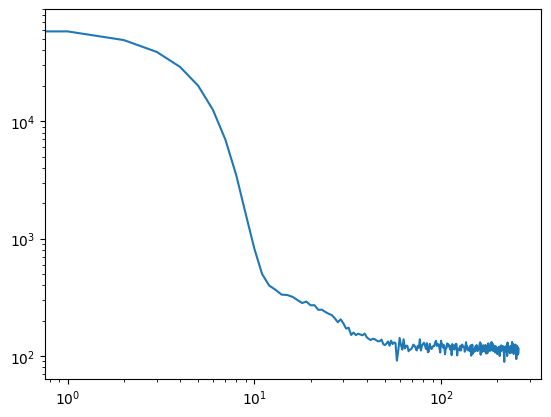

In [26]:
import matplotlib.pyplot as plt
plt.loglog(losses)

### Input model prediction into pyscf to compute dipole moment 

In [5]:
import os
os.environ['PYSCFAD_BACKEND']='torch'

import torch
from pyscf import gto

from pyscfad import numpy as pynp
from pyscfad import ops
from pyscfad.ml.scf import hf
import pyscf.pbc.tools.pyscf_ase as pyscf_ase

Using PyTorch backend.


/home/nigam/miniconda3/lib/python3.11/site-packages/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [6]:
from mlelec.data.pyscf_calculator import _instantiate_pyscf_mol
from mlelec.utils.twocenter_utils import fix_orbital_order, unfix_orbital_order
import mlelec.metrics as mlmetrics

In [7]:
import sys
import os
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')
        sys._jupyter_stdout = sys.stdout

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout
        sys._jupyter_stdout = sys.stdout

In [8]:
def compute_dipole_moment(frames, fock_predictions, overlaps):
    assert len(frames) == len(fock_predictions) == len(overlaps), "Length of frames, fock_predictions, and overlaps must be the same"
    dipoles  = []
    for i, frame in enumerate(frames):
        mol = _instantiate_pyscf_mol(frame)
        mf = hf.SCF(mol)
        fock = torch.autograd.Variable(fock_predictions[i].type(torch.float64), requires_grad=True)

        mo_energy, mo_coeff = mf.eig(fock, overlaps[i])
        mo_occ = mf.get_occ(mo_energy) # get_occ returns a numpy array
        mo_occ = ops.convert_to_tensor(mo_occ)
        dm1 = mf.make_rdm1(mo_coeff, mo_occ)
        dip = mf.dip_moment(dm=dm1)
        dipoles.append(dip)
    return torch.stack(dipoles)

In [33]:
#TEST set 

# with HiddenPrints():
with io.capture_output() as captured:

    fock_predictions = model.forward(ml_data.feat_test, return_type='tensor')
    # convert prediction back to pyscf order
    fock_predictions = unfix_orbital_order(fock_predictions, ml_data.test_frames, ml_data.molecule_data.aux_data['orbitals'])
    
    dipole_predictions = compute_dipole_moment(ml_data.test_frames, fock_predictions,ml_data.molecule_data.aux_data['overlap'][ml_data.test_idx])
    # very imp to pass the right overlap matrix


error = mlmetrics.L2_loss(dipole_predictions, ml_data.molecule_data.target['dipole_moment'][ml_data.test_idx])
print('(TEST) MSE on dipole', error/len(dipole_predictions)) 

(TEST) MSE on dipole tensor(0.3084, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


In [34]:
# Entire dataset 
with io.capture_output() as captured:

    fock_predictions = model.forward(ml_data.features, return_type='tensor')
    # convert prediction back to pyscf order 
    fock_predictions = unfix_orbital_order(fock_predictions, ml_data.structures, ml_data.molecule_data.aux_data['orbitals'])
    dipole_predictions = compute_dipole_moment(ml_data.structures, fock_predictions,ml_data.molecule_data.aux_data['overlap']); 

In [35]:
error = mlmetrics.L2_loss(dipole_predictions, ml_data.molecule_data.target['dipole_moment'])
print('MSE on dipole', error/len(dipole_predictions))

MSE on dipole tensor(0.2465, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


## 2. Indirect learning of dipole moment through pyscfad 

In [9]:
import mlelec.metrics as mlmetrics

In [10]:
import warnings 
def instantiate_mf(ml_data: MLDataset, fock_predictions, batch_indices):
    if len(batch_indices) != len(fock_predictions):
        warnings.warn('Converting shapes')
        fock_predictions = fock_predictions.reshape(1,*fock_predictions.shape)
    mfs = []
    fockvar = []
    for i, idx in enumerate(batch_indices):
        mol = _instantiate_pyscf_mol(ml_data.structures[idx])
        mf = hf.SCF(mol)
        fock = torch.autograd.Variable(fock_predictions[i].type(torch.float64), requires_grad=True)
        mfs.append(mf)
        fockvar.append(fock)
    return mfs, torch.stack(fockvar)

def compute_dipole_moment_frommf(mfs, fock_vars, overlaps):
    print(fock_vars.dtype, overlaps.dtype)
    dipoles  = []
    for i in range(len(mfs)):
        mf = mfs[i]
        fock = fock_vars[i]
        overlaps[i] = overlaps[i].to(fock)
        mo_energy, mo_coeff = mf.eig(fock, overlaps[i])
        mo_occ = mf.get_occ(mo_energy) # get_occ returns a numpy array
        mo_occ = ops.convert_to_tensor(mo_occ)
        dm1 = mf.make_rdm1(mo_coeff, mo_occ)
        dip = mf.dip_moment(dm=dm1)
        dipoles.append(dip)
    return torch.stack(dipoles)

In [18]:
def compute_dipole_moment_from_batchidx(ml_data: MLDataset, batch_fockvars, batch_indices, mfs):
    # Convert fock predictions back to pyscf order
    # Compute dipole moment for each molecule in batch
    batch_frames = [ml_data.structures[i] for i in batch_indices]
    batch_fock = unfix_orbital_order(batch_fockvars, batch_frames, ml_data.molecule_data.aux_data['orbitals'])
    batch_overlap = ml_data.molecule_data.aux_data['overlap'][batch_indices].to(batch_fock)
    print(len(batch_frames), len(batch_fock), len(batch_overlap))
    batch_mfs = [mfs[i] for i in batch_indices]
    return compute_dipole_moment_frommf(batch_mfs, batch_fock, batch_overlap)


In [12]:
from cmath import inf
best = inf
early_stop_criteria =  10 

In [13]:
model = LinearTargetModel(dataset = ml_data, nlayers = 1, nhidden = 16, bias = False, device = 'cuda')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=10, verbose=True)

val_interval = 10

In [ ]:
all_focks = model(ml_data.features , return_type='tensor').type(torch.float64)
all_mfs = instantiate_mf(ml_data, all_focks, idx = list(range(len(ml_))))[0]

In [17]:
train_focks = model(ml_data.feat_train , return_type='tensor').type(torch.float64)

train_mfs, train_focks = instantiate_mf(ml_data, train_focks, ml_data.train_idx)

val_focks = model(ml_data.feat_val, return_type='tensor').type(torch.float64)

val_mfs, val_focks = instantiate_mf(ml_data, val_focks, ml_data.val_idx)


In [16]:
loss_fn = getattr(mlmetrics, 'L2_loss')
losses=[]
early_stop_count = 0
for epoch in range(300):
    model.train(True)
    train_loss =0
    for i, data in enumerate(train_dl):
        optimizer.zero_grad()
        batch_indices = data['idx']
        # print(batch_indices)
        train_focks = model(data['input'], return_type='tensor', batch_indices=batch_indices).type(torch.float64)
        with io.capture_output() as captured:
        # with HiddenPrints():
            # if epoch == 0:
            #     train_mfs, train_focks = instantiate_mf(ml_data, train_focks, batch_indices )
            #     print(len(train_mfs), len(train_focks), len(batch_indices))
            train_dip_pred = compute_dipole_moment_from_batchidx(ml_data, train_focks, batch_indices=batch_indices, mfs=train_mfs)
        loss = loss_fn(train_dip_pred, ml_data.molecule_data.target['dipole_moment'][batch_indices])
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    # train_loss = loss_fn(torch.cat(train_pred), torch.cat(target))
    # print(train_loss - epoch_loss)
    losses.append(train_loss)
    # scheduler.step(train_loss)
    model.train(False)

    if epoch% val_interval == 0:
        val_loss = 0
        for i, data in enumerate(val_dl):
            batch_indices = data['idx']
            val_focks = model(data['input'], return_type='tensor', batch_indices=batch_indices).type(torch.float64)
            with io.capture_output() as captured:
            # with HiddenPrints():
                if epoch == 0:
                    val_mfs, val_focks = instantiate_mf(ml_data, val_focks, batch_indices )
                val_dip_pred = compute_dipole_moment_from_batchidx(ml_data, val_focks, batch_indices=batch_indices, mfs=val_mfs)
            print(val_dip_pred.shape, ml_data.molecule_data.target['dipole_moment'][batch_indices].shape, batch_indices)
            vloss = loss_fn(val_dip_pred, ml_data.molecule_data.target['dipole_moment'][batch_indices])
            val_loss += vloss.item()
        new_best = val_loss < best 
        if new_best:
            best = val_loss
            # torch.save(model.state_dict(), 'best_model_dipole.pt')
            early_stop_count = 0
        else: 
            early_stop_count+=1
        if early_stop_count > early_stop_criteria:
            print(f'Early stopping at epoch {epoch}')
            print(f'Epoch {epoch}, train loss {train_loss/len(ml_data.train_idx)}')

            print(f'Epoch {epoch} val loss {val_loss/len(ml_data.val_idx)}')
            # Save last best model
            break

        # val_loss = loss_fn(torch.cat(val_pred), torch.cat(val))
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, train loss {train_loss/len(ml_data.train_idx)}')

        print(f'Epoch {epoch} val loss {val_loss/len(ml_data.val_idx)}')
    

torch.Size([4, 3]) torch.Size([4, 3]) [199, 107, 41, 32]
torch.Size([4, 3]) torch.Size([4, 3]) [96, 95, 115, 147]
torch.Size([4, 3]) torch.Size([4, 3]) [68, 143, 57, 117]
torch.Size([4, 3]) torch.Size([4, 3]) [142, 24, 64, 140]
torch.Size([4, 3]) torch.Size([4, 3]) [13, 26, 44, 35]
torch.Size([4, 3]) torch.Size([4, 3]) [112, 9, 179, 14]
torch.Size([4, 3]) torch.Size([4, 3]) [146, 149, 10, 49]
torch.Size([4, 3]) torch.Size([4, 3]) [106, 94, 5, 89]
torch.Size([4, 3]) torch.Size([4, 3]) [83, 137, 158, 28]
torch.Size([3, 3]) torch.Size([3, 3]) [136, 144, 82]
Epoch 0, train loss 0.02341648604221277
Epoch 0 val loss 0.03470706547770126
torch.Size([3, 3]) torch.Size([4, 3]) [95, 24, 9, 89]


RuntimeError: The size of tensor a (3) must match the size of tensor b (4) at non-singleton dimension 0

In [ ]:
with io.capture_output() as captured:
    batch_indices = ml_data.test_idx
    test_fock_predictions = model.forward(ml_data.feat_test, return_type='tensor').type(torch.float64)
    # convert prediction back to pyscf order
    test_mfs, test_focks = instantiate_mf(ml_data, test_fock_predictions, batch_indices )
    test_dip_pred = compute_dipole_moment_from_batchidx(ml_data, test_fock_predictions, batch_indices=batch_indices, mfs=test_mfs)
    # very imp to pass the right overlap matrix


error = mlmetrics.L2_loss(test_dip_pred, ml_data.molecule_data.target['dipole_moment'][ml_data.test_idx])
print('(TEST) MSE on dipole', error/len(test_dip_pred))

(TEST) MSE on dipole tensor(3.6236e-12, device='cuda:0', dtype=torch.float64,
       grad_fn=<DivBackward0>)


# We can overfit on just rotated structures 

In [5]:
water_data = MoleculeDataset(mol_name='water_rotated', frame_slice=slice(0,100),  device='cuda', aux=['overlap', 'orbitals'], target=["fock", "dipole_moment"])
ml_data = MLDataset(molecule_data=water_data, device ='cuda', model_strategy = "coupled")

# ml_data._shuffle(random_seed=5380)
ml_data._split_indices(train_frac=0.4, val_frac=0.33)
#assumed args.model_type = 'acdc'
if ml_data.features is None: 
    ml_data._set_features(compute_features_for_target(ml_data, device='cuda'))



Loading structures
examples/data/water_rotated/sto-3g/fock.hickle
examples/data/water_rotated/sto-3g/dipole_moment.hickle
Computing features with default hypers


/home/nigam/miniconda3/lib/python3.11/site-packages/rascaline/systems/ase.py:57: UserWarning: periodic boundary conditions are disabled, but the cell matrix is not zero, we will set the cell to zero.
  warnings.warn(


In [6]:
train_dl, val_dl, test_dl = get_dataloader(ml_data, model_return= 'tensor')
# next(iter(train_dl))

## training on rotated structures 

In [7]:
model = LinearTargetModel(dataset = ml_data, nlayers = 1, nhidden = 16, bias = False, device = 'cuda')

In [8]:
from cmath import inf
best = inf
early_stop_criteria =  10 

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=10, verbose=True)
import mlelec.metrics as mlmetrics
val_interval = 10
loss_fn = getattr(mlmetrics, 'L2_loss')
losses=[]
early_stop_count = 0


In [10]:
for epoch in range(800):
    # train_pred = []
    # target=[]
    model.train(True)
    train_loss =0
    for i, data in enumerate(train_dl):
        optimizer.zero_grad()
        pred = model(data['input'], return_type='tensor', batch_indices=data['idx'])
        # target.append(data['output'])
        # train_pred.append(pred)
        loss = loss_fn(pred, data['output'])
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    # train_loss = loss_fn(torch.cat(train_pred), torch.cat(target))
    # print(train_loss - epoch_loss)
    losses.append(train_loss)
    # scheduler.step(train_loss)
    model.train(False)

    if epoch% val_interval == 0:
        # val_pred = []
        # val= []
        val_loss = 0
        for i, data in enumerate(val_dl):
            pred = model(data['input'], return_type='tensor', batch_indices=data['idx'])
            vloss = loss_fn(pred, data['output'])
            val_loss += vloss.item()
            # val.append(data['output'])
            # val_pred.append(pred)
        new_best = val_loss < best 
        if new_best:
            best = val_loss
            torch.save(model.state_dict(), 'best_model.pt')
            early_stop_count = 0
        else: 
            early_stop_count+=1
        if early_stop_count > early_stop_criteria:
            print(f'Early stopping at epoch {epoch}')
            print(f'Epoch {epoch}, train loss {train_loss/len(ml_data.train_idx)}')

            print(f'Epoch {epoch} val loss {val_loss/len(ml_data.val_idx)}')
            # Save last best model
            break

        # val_loss = loss_fn(torch.cat(val_pred), torch.cat(val))
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, train loss {train_loss/len(ml_data.train_idx)}')

        print(f'Epoch {epoch} val loss {val_loss/len(ml_data.val_idx)}')
    

Epoch 0, train loss 480.6221471109374
Epoch 0 val loss 479.6697718800906
Epoch 10, train loss 471.067940931348
Epoch 10 val loss 470.07432046560285
Epoch 20, train loss 460.5452746793023
Epoch 20 val loss 459.41386976932336
Epoch 30, train loss 448.51430957752297
Epoch 30 val loss 447.2212151794173
Epoch 40, train loss 434.8163762364184
Epoch 40 val loss 433.35173403945134
Epoch 50, train loss 419.394049535435
Epoch 50 val loss 417.75839236533676
Epoch 60, train loss 402.31622244719415
Epoch 60 val loss 400.5242073677908
Epoch 70, train loss 383.78575865653283
Epoch 70 val loss 381.8637295122723
Epoch 80, train loss 364.1001015139956
Epoch 80 val loss 362.08097041657
Epoch 90, train loss 343.5972824317196
Epoch 90 val loss 341.51489354079655
Epoch 100, train loss 322.60118737197865
Epoch 100 val loss 320.48553902797124
Epoch 110, train loss 301.38706441313224
Epoch 110 val loss 299.2625421243271
Epoch 120, train loss 280.17292045612527
Epoch 120 val loss 278.05829901281874
Epoch 130, t

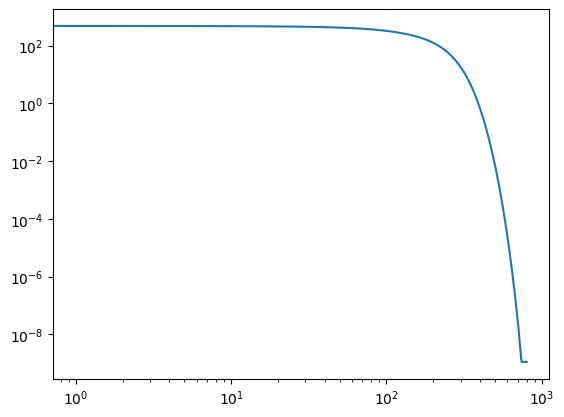

In [11]:
import matplotlib.pyplot as plt
plt.loglog(losses)

### Input model prediction into pyscf to compute dipole moment 

In [ ]:
import os
os.environ['PYSCFAD_BACKEND']='torch'

import torch
from pyscf import gto

from pyscfad import numpy as pynp
from pyscfad import ops
from pyscfad.ml.scf import hf
import pyscf.pbc.tools.pyscf_ase as pyscf_ase

Using PyTorch backend.


/home/nigam/miniconda3/lib/python3.11/site-packages/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


In [ ]:
from mlelec.data.pyscf_calculator import _instantiate_pyscf_mol
from mlelec.utils.twocenter_utils import fix_orbital_order, unfix_orbital_order
import mlelec.metrics as mlmetrics

In [ ]:
import sys
import os
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')
        sys._jupyter_stdout = sys.stdout

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout
        sys._jupyter_stdout = sys.stdout

In [ ]:
def compute_dipole_moment(frames, fock_predictions, overlaps):
    assert len(frames) == len(fock_predictions) == len(overlaps), "Length of frames, fock_predictions, and overlaps must be the same"
    dipoles  = []
    for i, frame in enumerate(frames):
        mol = _instantiate_pyscf_mol(frame)
        mf = hf.SCF(mol)
        fock = torch.autograd.Variable(fock_predictions[i].type(torch.float64), requires_grad=True)

        mo_energy, mo_coeff = mf.eig(fock, overlaps[i])
        mo_occ = mf.get_occ(mo_energy) # get_occ returns a numpy array
        mo_occ = ops.convert_to_tensor(mo_occ)
        dm1 = mf.make_rdm1(mo_coeff, mo_occ)
        dip = mf.dip_moment(dm=dm1)
        dipoles.append(dip)
    return torch.stack(dipoles)

In [ ]:
#TEST set 

# with HiddenPrints():
with io.capture_output() as captured:

    fock_predictions = model.forward(ml_data.feat_test, return_type='tensor')
    # convert prediction back to pyscf order
    fock_predictions = unfix_orbital_order(fock_predictions, ml_data.test_structures, ml_data.molecule_data.aux_data['orbitals'])
    
    dipole_predictions = compute_dipole_moment(ml_data.test_structures, fock_predictions,ml_data.molecule_data.aux_data['overlap'][ml_data.test_idx])
    # very imp to pass the right overlap matrix


error = mlmetrics.L2_loss(dipole_predictions, ml_data.molecule_data.target['dipole_moment'][ml_data.test_idx])
print('(TEST) MSE on dipole', error/len(dipole_predictions)) 

NameError: name 'model' is not defined

In [ ]:
# Entire dataset 
with io.capture_output() as captured:

    fock_predictions = model.forward(ml_data.features, return_type='tensor')
    # convert prediction back to pyscf order 
    fock_predictions = unfix_orbital_order(fock_predictions, ml_data.structures, ml_data.molecule_data.aux_data['orbitals'])
    dipole_predictions = compute_dipole_moment(ml_data.structures, fock_predictions,ml_data.molecule_data.aux_data['overlap']); 

In [ ]:
error = mlmetrics.L2_loss(dipole_predictions, ml_data.molecule_data.target['dipole_moment'])
print('MSE on dipole', error/len(dipole_predictions))

MSE on dipole tensor(1.3298e-12, device='cuda:0', dtype=torch.float64,
       grad_fn=<DivBackward0>)


## test equivariance of prediction/features 

In [ ]:
import hickle
rotations = hickle.load('examples/data/water_rotated/rotations.hickle')
r1 = model.forward(ml_data.features, return_type='coupled_blocks')

In [ ]:
r1 = ml_data.features

In [ ]:
from mlelec.utils.metatensor_utils import labels_where
from mlelec.utils.symmetry import _wigner_d_real
import numpy as np 
from metatensor import Labels
for i, (k,b) in enumerate(r1.items()):
    unrot_idx  = labels_where(b.samples, selection = Labels(['structure'], values = np.asarray([[0]]).reshape(-1,1)), 
    return_idx=True )[-1]
    rot_idx = labels_where(b.samples, selection = Labels(['structure'], values = np.asarray([[ml_data.test_idx]]).reshape(-1,1)), return_idx=True)[-1]
    # L = k['L']
    L = k['spherical_harmonics_l']
    wd = _wigner_d_real(L, *rotations[ml_data.test_idx-1]).to(b.values)
    if torch.linalg.norm(wd@b.values[unrot_idx] - b.values[rot_idx])>1e-7:
        print(torch.linalg.norm(wd@b.values[unrot_idx] - b.values[rot_idx]))

## Indirect learning of dipole moment through pyscfad 

In [ ]:
import mlelec.metrics as mlmetrics

In [ ]:
import warnings 
def instantiate_mf(ml_data: MLDataset, fock_predictions, batch_indices):
    if len(batch_indices) != len(fock_predictions):
        warnings.warn('Converting shapes')
        fock_predictions = fock_predictions.reshape(1,*fock_predictions.shape)
    mfs = []
    fockvar = []
    for i, idx in enumerate(batch_indices):
        mol = _instantiate_pyscf_mol(ml_data.structures[idx])
        mf = hf.SCF(mol)
        fock = torch.autograd.Variable(fock_predictions[i].type(torch.float64), requires_grad=True)
        mfs.append(mf)
        fockvar.append(fock)
    return mfs, torch.cat(fockvar)

def compute_dipole_moment_frommf(mfs, fock_vars, overlaps):
    print(fock_vars.dtype, overlaps.dtype)
    dipoles  = []
    for i in range(len(mfs)):
        mf = mfs[i]
        fock = fock_vars[i]
        overlaps[i] = overlaps[i].to(fock)
        mo_energy, mo_coeff = mf.eig(fock, overlaps[i])
        mo_occ = mf.get_occ(mo_energy) # get_occ returns a numpy array
        mo_occ = ops.convert_to_tensor(mo_occ)
        dm1 = mf.make_rdm1(mo_coeff, mo_occ)
        dip = mf.dip_moment(dm=dm1)
        dipoles.append(dip)
    return torch.stack(dipoles)

In [ ]:
def compute_dipole_moment_from_batchidx(ml_data: MLDataset, batch_fockvars, batch_indices, mfs):
    # Convert fock predictions back to pyscf order
    # Compute dipole moment for each molecule in batch
    batch_frames = [ml_data.structures[i] for i in batch_indices]
    batch_fock = unfix_orbital_order(batch_fockvars, batch_frames, ml_data.molecule_data.aux_data['orbitals'])
    batch_overlap = ml_data.molecule_data.aux_data['overlap'][batch_indices].to(batch_fock)
    print(len(batch_frames), len(batch_fock), len(batch_overlap))
    return compute_dipole_moment_frommf(mfs, batch_fock, batch_overlap)


In [ ]:
from cmath import inf
best = inf
early_stop_criteria =  10 

In [ ]:
model = LinearTargetModel(dataset = ml_data, nlayers = 1, nhidden = 16, bias = False, device = 'cuda')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=10, verbose=True)

val_interval = 10

In [ ]:
train_focks.shape

torch.Size([7, 7])

In [ ]:
loss_fn = getattr(mlmetrics, 'L2_loss')
losses=[]
early_stop_count = 0
for epoch in range(300):
    model.train(True)
    train_loss =0
    for i, data in enumerate(train_dl):
        optimizer.zero_grad()
        batch_indices = data['idx']
        # print(batch_indices)
        train_focks = model(data['input'], return_type='tensor', batch_indices=batch_indices).type(torch.float64)
        with io.capture_output() as captured:
        # with HiddenPrints():
            if epoch == 0:
                train_mfs, train_focks = instantiate_mf(ml_data, train_focks, batch_indices )
            train_dip_pred = compute_dipole_moment_from_batchidx(ml_data, train_focks, batch_indices=batch_indices, mfs=train_mfs)
            loss = loss_fn(train_dip_pred, ml_data.molecule_data.target['dipole_moment'][batch_indices])
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
    # train_loss = loss_fn(torch.cat(train_pred), torch.cat(target))
    # print(train_loss - epoch_loss)
    losses.append(train_loss)
    # scheduler.step(train_loss)
    model.train(False)

    if epoch% val_interval == 0:
        val_loss = 0
        for i, data in enumerate(val_dl):
            batch_indices = data['idx']
            val_focks = model(data['input'], return_type='tensor', batch_indices=batch_indices).type(torch.float64)
            with io.capture_output() as captured:
            # with HiddenPrints():
                if epoch == 0:
                    val_mfs, train_focks = instantiate_mf(ml_data, val_focks, batch_indices )
                val_dip_pred = compute_dipole_moment_from_batchidx(ml_data, val_focks, batch_indices=batch_indices, mfs=val_mfs)
            vloss = loss_fn(val_dip_pred, ml_data.molecule_data.target['dipole_moment'][batch_indices])
            val_loss += vloss.item()
        new_best = val_loss < best 
        if new_best:
            best = val_loss
            # torch.save(model.state_dict(), 'best_model_dipole.pt')
            early_stop_count = 0
        else: 
            early_stop_count+=1
        if early_stop_count > early_stop_criteria:
            print(f'Early stopping at epoch {epoch}')
            print(f'Epoch {epoch}, train loss {train_loss/len(ml_data.train_idx)}')

            print(f'Epoch {epoch} val loss {val_loss/len(ml_data.val_idx)}')
            # Save last best model
            break

        # val_loss = loss_fn(torch.cat(val_pred), torch.cat(val))
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, train loss {train_loss/len(ml_data.train_idx)}')

        print(f'Epoch {epoch} val loss {val_loss/len(ml_data.val_idx)}')
    

Epoch 0, train loss 23.890822617507865
Epoch 0 val loss 23.890827610345298
Epoch 10, train loss 0.25844257845675
Epoch 10 val loss 0.2808343047151666
Epoch 20, train loss 0.07868898373478944
Epoch 20 val loss 0.056642496020292366
Epoch 30, train loss 0.0030995529533909684
Epoch 30 val loss 0.005510526882811492
Epoch 40, train loss 0.014536936556569131
Epoch 40 val loss 0.013285529380427562
Epoch 50, train loss 0.0010134080183643297
Epoch 50 val loss 0.0004910347735883092
Epoch 60, train loss 0.00106229340354553
Epoch 60 val loss 0.001180861165248113
Epoch 70, train loss 0.0004542081681794029
Epoch 70 val loss 0.0003260449352048469
Epoch 80, train loss 4.7677173606573505e-05
Epoch 80 val loss 7.065522318653241e-05
Epoch 90, train loss 7.915291068666748e-05
Epoch 90 val loss 6.283436181653282e-05
Epoch 100, train loss 2.127319029450375e-06
Epoch 100 val loss 4.63705931478635e-06
Epoch 110, train loss 1.0708887809057119e-05
Epoch 110 val loss 8.727589505492225e-06
Epoch 120, train loss 2.

In [ ]:
with io.capture_output() as captured:
    batch_indices = ml_data.test_idx
    test_fock_predictions = model.forward(ml_data.feat_test, return_type='tensor').type(torch.float64)
    # convert prediction back to pyscf order
    test_mfs, test_focks = instantiate_mf(ml_data, test_fock_predictions, batch_indices )
    test_dip_pred = compute_dipole_moment_from_batchidx(ml_data, test_fock_predictions, batch_indices=batch_indices, mfs=test_mfs)
    # very imp to pass the right overlap matrix


error = mlmetrics.L2_loss(test_dip_pred, ml_data.molecule_data.target['dipole_moment'][ml_data.test_idx])
print('(TEST) MSE on dipole', error/len(test_dip_pred))

(TEST) MSE on dipole tensor(3.6236e-12, device='cuda:0', dtype=torch.float64,
       grad_fn=<DivBackward0>)


## Calculate the target dipole moment of water molecule in case data not found

In [ ]:
from mlelec.data.pyscf_calculator import calculator

calc= calculator(
        path="examples/data/water_1000/",
        mol_name="water_1000",
        frame_slice="0:1",
        target = ['fock', 'dipole_moment'],
    )
calc.calculate(   basis_set="sto-3g", verbose = 1)

Loading
Number of frames:  1
['0 O 1s    ', '0 O 2s    ', '0 O 2px   ', '0 O 2py   ', '0 O 2pz   ', '1 H 1s    ', '2 H 1s    ']
converged: True
Dipole moment(X, Y, Z, Debye):  1.50259,  1.24095,  0.00000


In [ ]:
calc.ao_labels

defaultdict(list, {8: ['1s', '2s', '2px', '2py', '2pz'], 1: ['1s']})

In [ ]:
calc.save_results(path= 'examples/data/water/')

1 s
2 s
2 px
2 py
2 pz
1 s
{8: [[1, 0, 0], [2, 0, 0], [2, 1, 1], [2, 1, -1], [2, 1, 0]], 1: [[1, 0, 0]]}
All done, results saved at:  examples/data/water/


/home/nigam/miniconda3/lib/python3.11/site-packages/hickle/lookup.py:1491: SerializedWarning: 'Tensor' type not understood, data is serialized:
  warnings.warn(


## grad of dipole moment vector

In [ ]:
https://stackoverflow.com/questions/62067400/understanding-accumulated-gradients-in-pytorch
    

In [ ]:
# grad of dipole moment


for ifr, pred in enumerate(predicted_xyz[:]):
    #gradient of the x component of the p vector
    gradients[ifr][:, 0,:] = torch.autograd.grad(pred[0], systems[ifr].positions, retain_graph = True)[0]
    #gradient of the y component of the p vector
    gradients[ifr][:, 1,:] = torch.autograd.grad(pred[1], systems[ifr].positions, retain_graph = True)[0]
    #gradient of the z component of the p vector
    gradients[ifr][:, 2,:] = torch.autograd.grad(pred[2], systems[ifr].positions, retain_graph = True)[0]

NameError: name 'predicted_xyz' is not defined